# Introducción al manejo de datos temporales

Los datos temporales son una forma de datos que se utilizan para analizar el comportamiento de una variable a lo largo del tiempo. Suelen denominarse ejecuciones de un proceso estocástico y se utilizan para predecir el comportamiento futuro de una variable. En este notebook se presentan los conceptos básicos de los datos temporales y cómo se pueden analizar utilizando Python.

El libro de Forecasting: Principles and Practice de Rob J Hyndman y George Athanasopoulos es una excelente referencia para aprender sobre el análisis de series temporales. Se puede acceder a la versión en línea de este libro en https://otexts.com/fpp3/ y será una referencia útil para este notebook.

Usaremos datos de demanda energética en colombia, los cuales se encuentran adjuntos en el repositorio de github.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import global_vars as gv

In [6]:
# Cargamos los datos
de = pd.read_csv(f'{gv.GLOBAL_PATH}/data/demanda_energetica.csv').drop('Unnamed: 0', axis=1)

In [7]:
# Mostramos los primeros registros
de.head()

,Dt,DE_SIN,Gn,DNA,Exp,Imp,years,meses,dias_sem,year_month,dia_mes
0,2006-01-01,1.039694e+08,1.044113e+08,75870.0,524629.52,6860.05,2006,1,domingo,ene. 2006,31
1,2006-01-02,1.248597e+08,1.305885e+08,77810.0,5806624.00,NaN,2006,1,lunes,ene. 2006,31
2,2006-01-03,1.319875e+08,1.377685e+08,106330.0,5887328.00,NaN,2006,1,martes,ene. 2006,31
3,2006-01-04,1.319963e+08,1.376072e+08,274260.0,5885184.00,NaN,2006,1,miércoles,ene. 2006,31
4,2006-01-05,1.311093e+08,1.367001e+08,270260.0,5861120.00,NaN,2006,1,jueves,ene. 2006,31


Las columnas de los datos son:
- Dt: Fecha
- DE_SIN: Demanda energética en el Sistema Interconectado Nacional
- Gn: Generación neta
- DNA: Demanda no atendida
- Exp: Exportaciones
- Imp: Importaciones
- years: Año
- meses: Mes
- dias_sem: Día de la semana
- year_motnh: Año y mes
- dia_mes: Día del mes

In [9]:
# Convertimos la columna Dt a datetime
de['Dt'] = pd.to_datetime(de['Dt'])

In [14]:
de = de.loc[de['Dt'] <= '2019-12-31']

In [15]:
# Verificamos los tipos de datos
de.dtypes

Dt            datetime64[ns]
DE_SIN               float64
Gn                   float64
DNA                  float64
Exp                  float64
Imp                  float64
years                  int64
meses                  int64
dias_sem              object
year_month            object
dia_mes                int64
dtype: object

# Análisis exploratorio

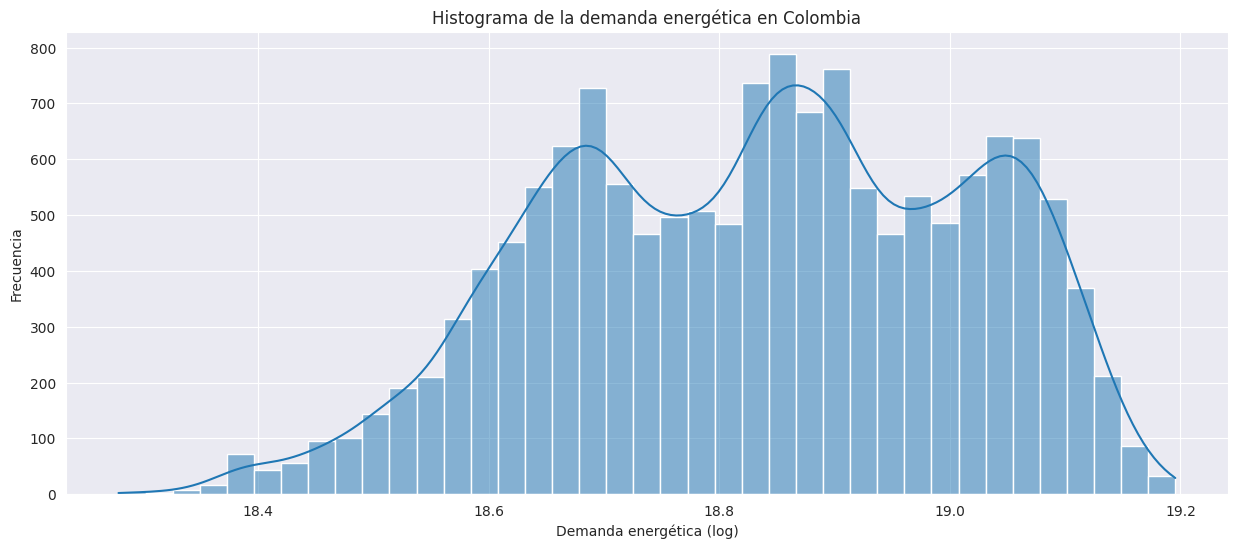

In [61]:
# Grafico del logaritmo de la demanda energética (histograma)
plt.figure(figsize=(15, 6))
sns.histplot(np.log(de['DE_SIN']), kde=True)
plt.title('Histograma de la demanda energética en Colombia')
plt.xlabel('Demanda energética (log)')
plt.ylabel('Frecuencia')
plt.show()

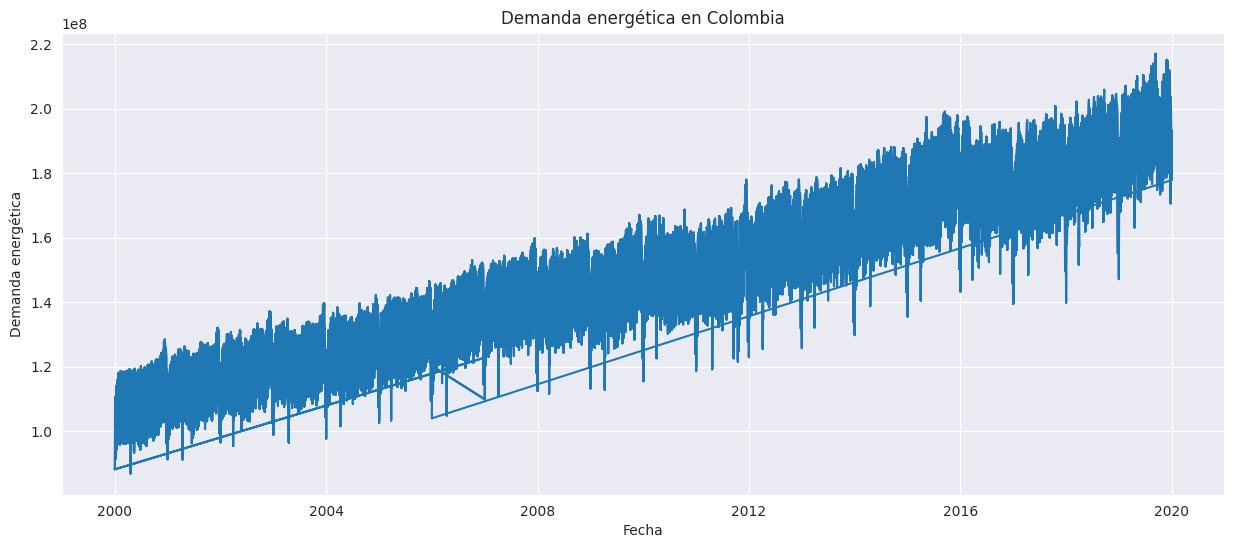

In [16]:
# Graficamos la demanda energética hasta el 31 de diciembre de 2019
plt.figure(figsize=(15, 6))
plt.plot(de['Dt'], de['DE_SIN'])
plt.title('Demanda energética en Colombia')
plt.xlabel('Fecha')
plt.ylabel('Demanda energética')
plt.show()

In [62]:
# Agregamos la serie de tiempo por mes
de['year_month'] = de['Dt'].dt.to_period('M')
de_month = de.groupby('year_month')['DE_SIN'].sum()
de_month.index = de_month.index.to_timestamp()

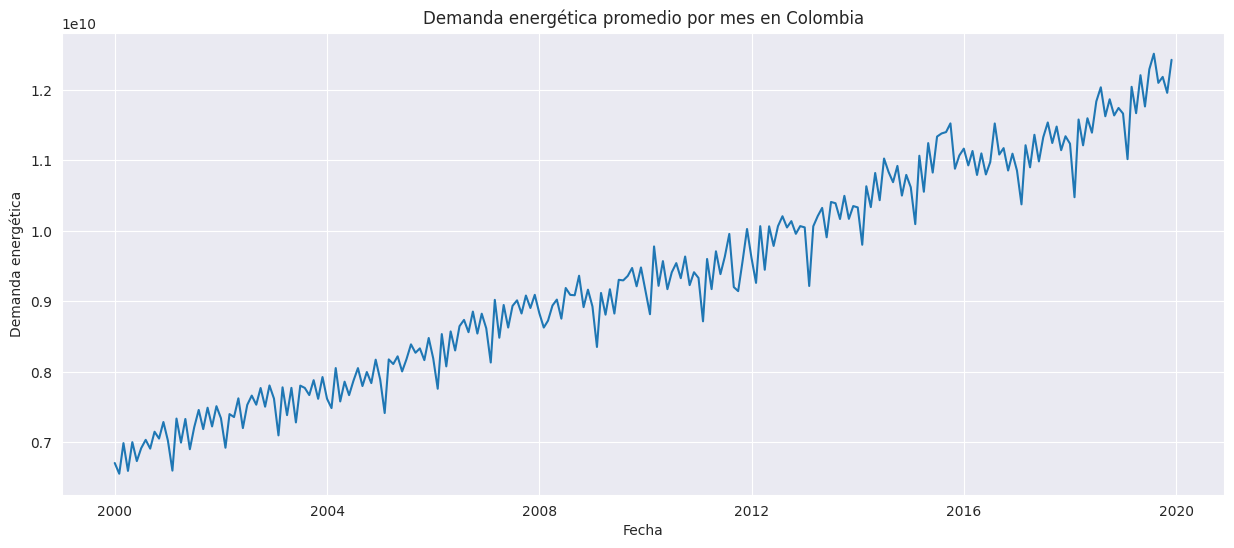

In [63]:
# Graficamos la demanda energética promedio por mes
plt.figure(figsize=(15, 6))
plt.plot(de_month)
plt.title('Demanda energética promedio por mes en Colombia')
plt.xlabel('Fecha')
plt.ylabel('Demanda energética')
plt.show()

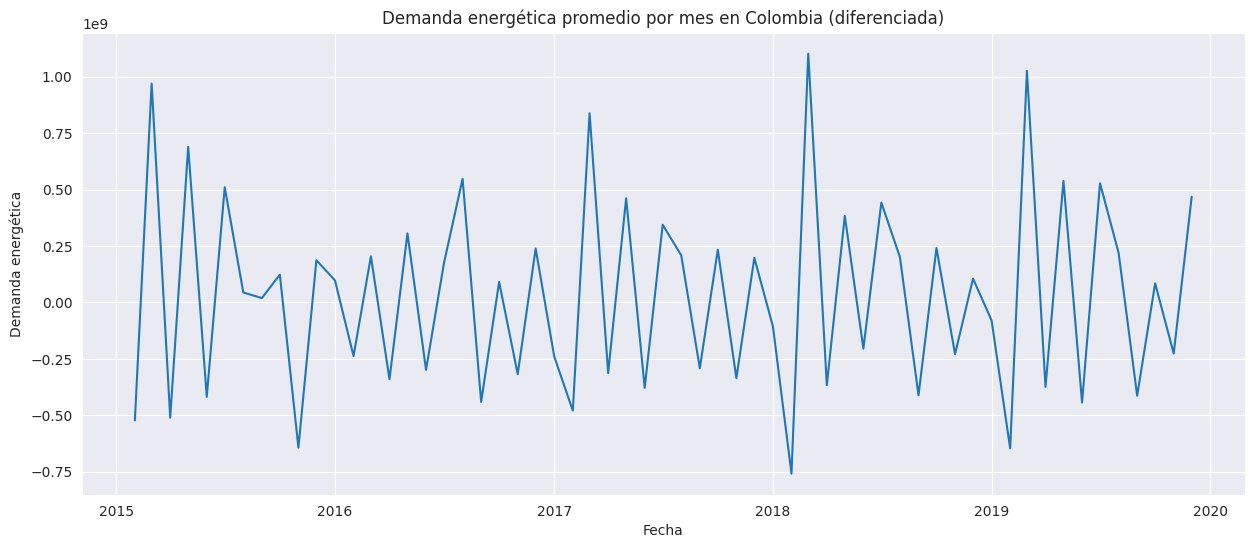

In [65]:
# Graficar serie diferenciada
de_month_diff = de_month.diff().dropna()
de_month_diff = de_month_diff[de_month_diff.index >= '2015-02-01']
plt.figure(figsize=(15, 6))
plt.plot(de_month_diff)
plt.title('Demanda energética promedio por mes en Colombia (diferenciada)')
plt.xlabel('Fecha')
plt.ylabel('Demanda energética')
plt.show()

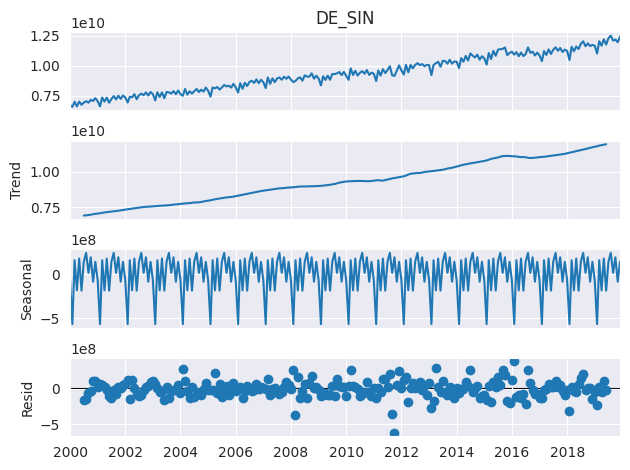

In [70]:
# Graficar descomposicion de la serie con tamaño 15,6
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(de_month, model='additive')
decomp.plot()
plt.show()

In [31]:
# Divimos los datos en entrenamiento y prueba (80% - 20%)
de_train = de_month.loc[de_month.index <= '2018-12-31']
de_test = de_month.loc[de_month.index > '2018-12-31']

In [32]:
de_train.shape, de_test.shape

((228,), (12,))

## Métodos de suaivización

### Promedio móvil
El promedio móvil es una técnica de suavización de series temporales que se utiliza para suavizar los datos eliminando el ruido y las fluctuaciones. Consiste en calcular el promedio de un número fijo de observaciones en un intervalo de tiempo específico. El promedio móvil se puede calcular utilizando la función rolling() de pandas.

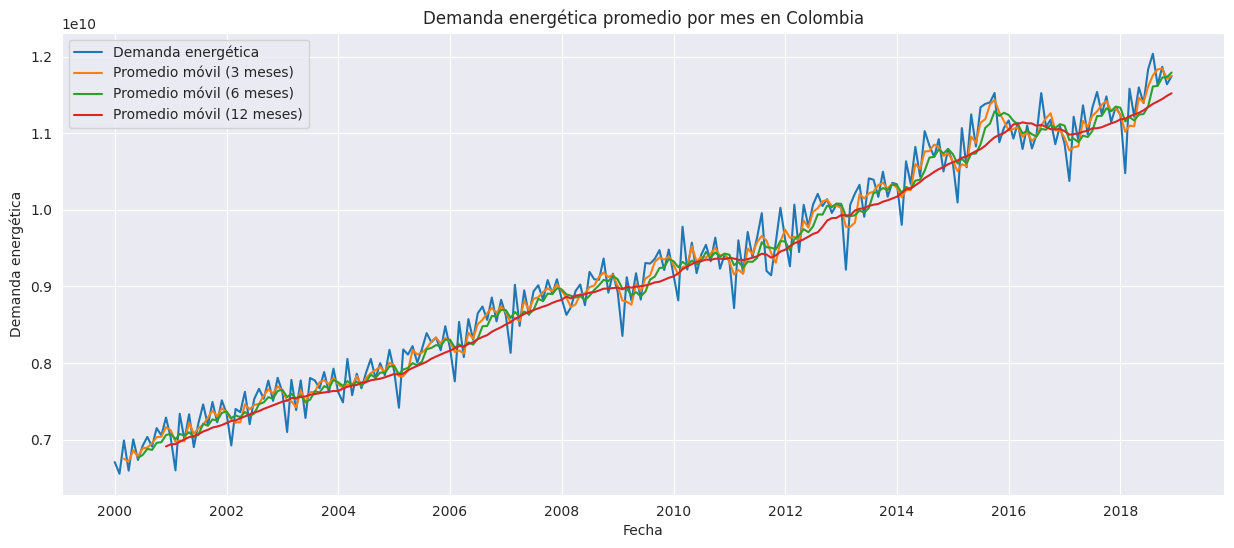

In [35]:
# Calculamos el promedio móvil para diferentes ventanas y los graficamos
plt.figure(figsize=(15, 6))
plt.plot(de_train, label='Demanda energética')
plt.plot(de_train.rolling(window=3).mean(), label='Promedio móvil (3 meses)')
plt.plot(de_train.rolling(window=6).mean(), label='Promedio móvil (6 meses)')
plt.plot(de_train.rolling(window=12).mean(), label='Promedio móvil (12 meses)')
plt.title('Demanda energética promedio por mes en Colombia')
plt.xlabel('Fecha')
plt.ylabel('Demanda energética')
plt.legend()
plt.show()

In [36]:
# Calculamos el error cuadrático medio para diferentes ventanas
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [40]:
# Ventana de 3 meses
print(f'RMSE para ventana de 3 meses: {rmse(de_train[2:], de_train.rolling(window=3).mean()[2:])}')
# Ventana de 6 meses
print(f'RMSE para ventana de 6 meses: {rmse(de_train[5:], de_train.rolling(window=6).mean()[5:])}')
# Ventana de 12 meses
print(f'RMSE para ventana de 12 meses: {rmse(de_train[11:], de_train.rolling(window=12).mean()[11:])}')

RMSE para ventana de 3 meses: 199462435.2060973
RMSE para ventana de 6 meses: 237375140.2272637
RMSE para ventana de 12 meses: 286745550.88408315


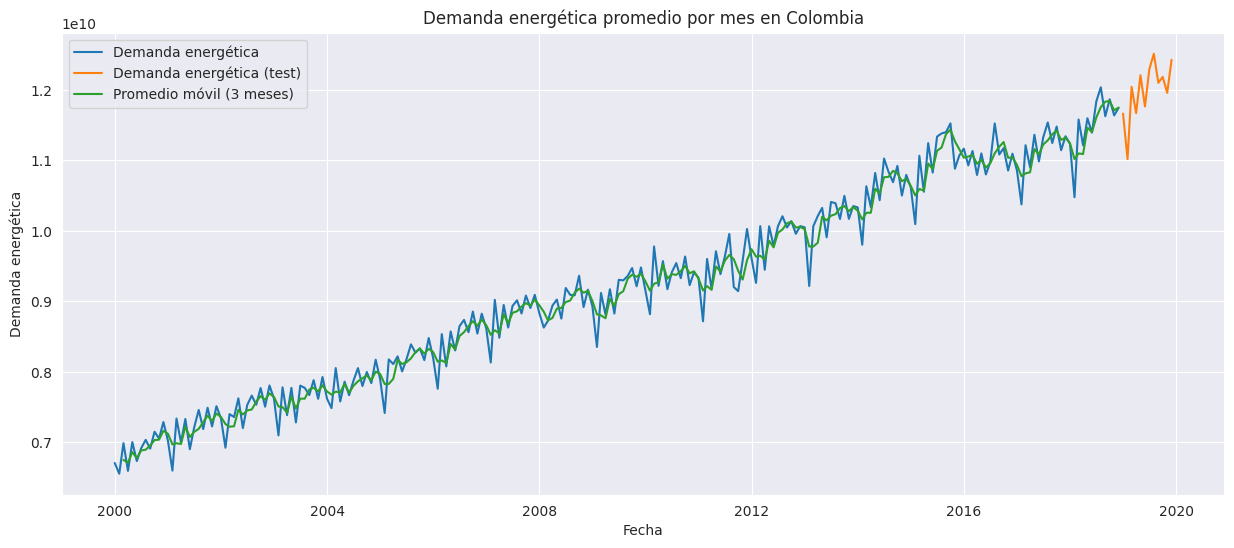

In [43]:
# Predicción con promedio móvil en el conjunto de prueba
plt.figure(figsize=(15, 6))
plt.plot(de_train, label='Demanda energética')
plt.plot(de_test, label='Demanda energética (test)')
plt.plot(de_train.rolling(window=3).mean(), label='Promedio móvil (3 meses)')
plt.title('Demanda energética promedio por mes en Colombia')
plt.xlabel('Fecha')
plt.ylabel('Demanda energética')
plt.legend()
plt.show()

### Suavización exponencial

El suavizado exponencial es una técnica de suavizado de series temporales que se utiliza para suavizar los datos eliminando el ruido y las fluctuaciones. Consiste en asignar un peso exponencialmente decreciente a las observaciones anteriores. El suavizado exponencial se puede calcular utilizando la función ewm() de pandas.

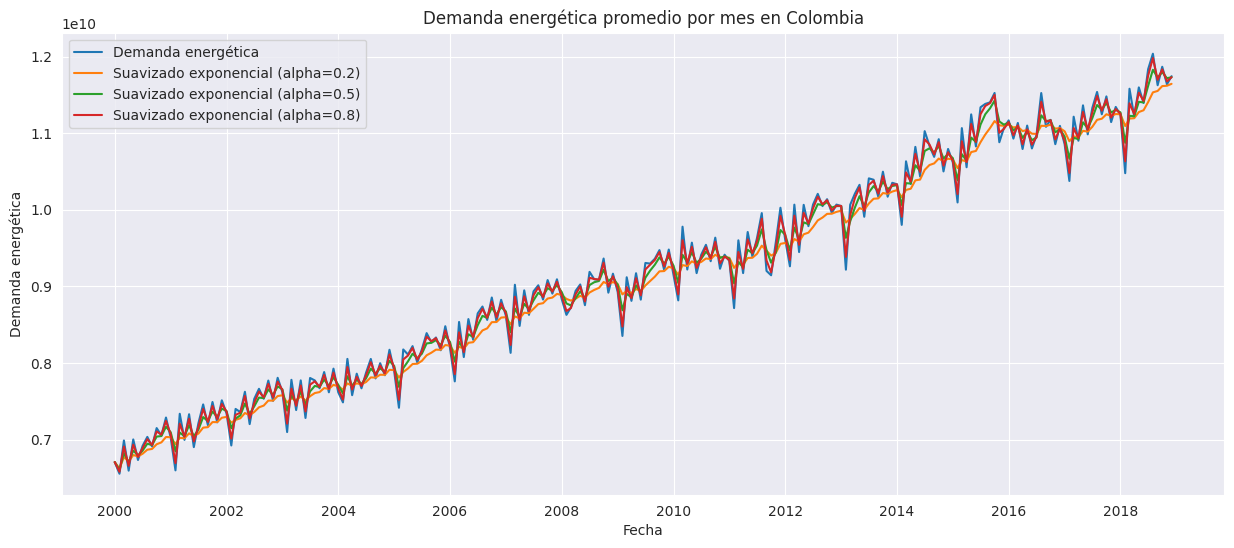

In [45]:
# Calculamos el suavizado exponencial y graficamos
plt.figure(figsize=(15, 6))
plt.plot(de_train, label='Demanda energética')
plt.plot(de_train.ewm(alpha=0.2).mean(), label='Suavizado exponencial (alpha=0.2)')
plt.plot(de_train.ewm(alpha=0.5).mean(), label='Suavizado exponencial (alpha=0.5)')
plt.plot(de_train.ewm(alpha=0.8).mean(), label='Suavizado exponencial (alpha=0.8)')
plt.title('Demanda energética promedio por mes en Colombia')
plt.xlabel('Fecha')
plt.ylabel('Demanda energética')
plt.legend()
plt.show()

In [46]:
# Calculamos el error cuadrático medio para diferentes alphas
# Alpha de 0.2
print(f'RMSE para alpha de 0.2: {rmse(de_train, de_train.ewm(alpha=0.2).mean())}')
# Alpha de 0.5
print(f'RMSE para alpha de 0.5: {rmse(de_train, de_train.ewm(alpha=0.5).mean())}')
# Alpha de 0.8
print(f'RMSE para alpha de 0.8: {rmse(de_train, de_train.ewm(alpha=0.8).mean())}')

RMSE para alpha de 0.2: 235185855.8052483
RMSE para alpha de 0.5: 150370382.00876105
RMSE para alpha de 0.8: 68334234.79698262


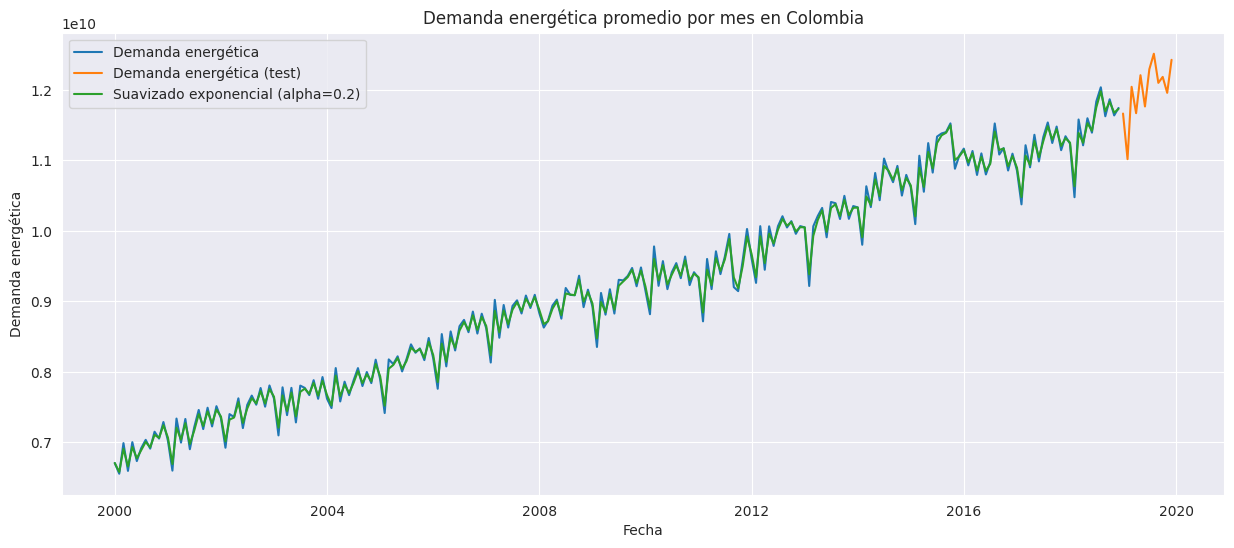

In [51]:
# Predicción con suavizado exponencial en el conjunto de prueba
plt.figure(figsize=(15, 6))
plt.plot(de_train, label='Demanda energética')
plt.plot(de_test, label='Demanda energética (test)')
plt.plot(de_train.ewm(alpha=0.8).mean(), label='Suavizado exponencial (alpha=0.2)')
plt.title('Demanda energética promedio por mes en Colombia')
plt.xlabel('Fecha')
plt.ylabel('Demanda energética')
plt.legend()
plt.show()

### Suavización de Holt-Winters

In [56]:
# Importamos la librería
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [57]:
# Ajustamos el modelo
model = ExponentialSmoothing(de_train, trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()

/home/chidalgo/git/DS_Course/venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [74]:
# Predicción
de_pred = model_fit.forecast(24)

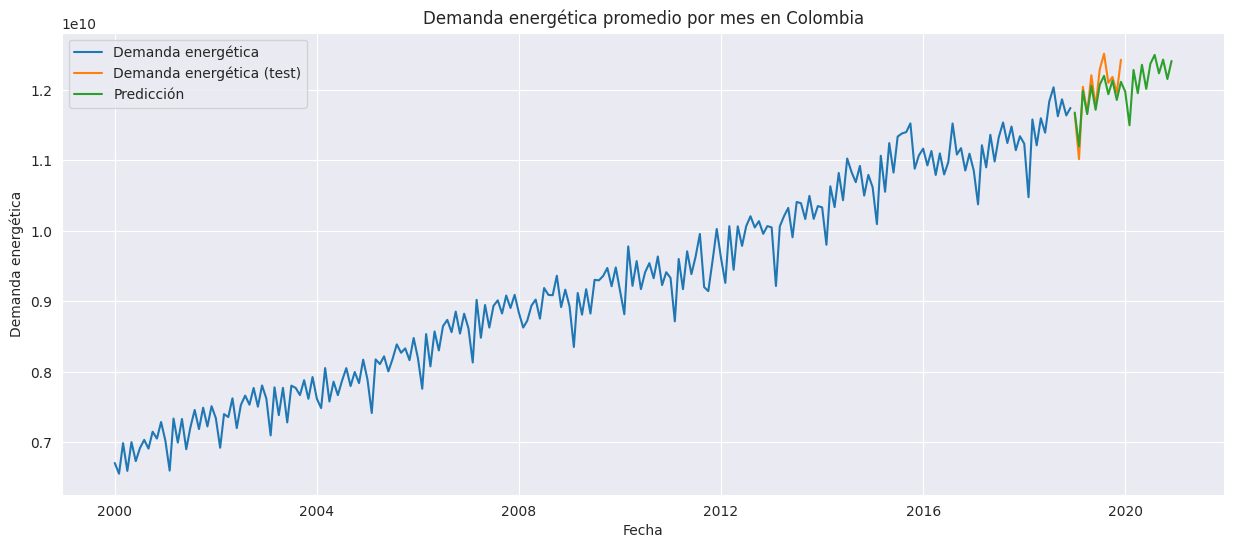

In [75]:
# Graficamos la predicción
plt.figure(figsize=(15, 6))
plt.plot(de_train, label='Demanda energética')
plt.plot(de_test, label='Demanda energética (test)')
plt.plot(de_pred, label='Predicción')
plt.title('Demanda energética promedio por mes en Colombia')
plt.xlabel('Fecha')
plt.ylabel('Demanda energética')
plt.legend()
plt.show()

In [71]:
# Calculamos el error absoluto medio
from sklearn.metrics import mean_absolute_error
print(f'MAE: {mean_absolute_error(de_test, de_pred)}')


MAE: 135305293.06061506


In [73]:
pd.DataFrame({'real': np.log(de_test), 'pred': np.log(de_pred)})

,real,pred
2019-01-01,23.179846,23.181080
2019-02-01,23.122827,23.139376
2019-03-01,23.211861,23.207043
2019-04-01,23.180313,23.179236
2019-05-01,23.225425,23.213122
2019-06-01,23.188440,23.184384
2019-07-01,23.232347,23.214438
2019-08-01,23.250082,23.224677
2019-09-01,23.216495,23.203085
2019-10-01,23.223461,23.219208
